In [21]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

category_to_index = {
    5: 0,  # Backhand
    6: 1,  # Forehand
    7: 2,  # Ready Position
    8: 3   # Serve
}

class TennisPoseKeypointsDataset(Dataset):
    def __init__(self, annotations_folder, images_folder, transform=None):
        self.annotations_folder = annotations_folder
        self.images_folder = images_folder
        self.transform = transform

        self.image_paths = []
        self.keypoints = []
        self.labels = []

        # Load annotations from multiple JSON files in the folder
        self._load_annotations()

    def _load_annotations(self):
        # Iterate over all JSON files in the annotations folder
        for filename in os.listdir(self.annotations_folder):
            if filename.endswith(".json"):
                annotations_file = os.path.join(self.annotations_folder, filename)

                # Open and read the JSON file
                with open(annotations_file) as f:
                    data = json.load(f)

                # Create a mapping from image_id to path from the JSON "images" section
                image_id_to_path = {
                    img["id"]: img["path"].replace("..", ".")
                    for img in data["images"]
                }

                # Iterate over the annotations and match with the images
                for annotation in data["annotations"]:
                    image_id = annotation["image_id"]
                    keypoints = torch.tensor(annotation["keypoints"]).view(-1, 3)

                    # Convert category_id to class index
                    category_id = annotation["category_id"]
                    label = category_to_index.get(category_id, -1)  # Use -1 for invalid categories

                    # Get the corresponding image path
                    image_path = image_id_to_path.get(image_id)

                    # Check if the image path is valid
                    if image_path and os.path.exists(image_path) and label != -1:
                        self.image_paths.append(image_path)
                        self.keypoints.append(keypoints)
                        self.labels.append(label)
                    else:
                        print(f"Skipping missing image or invalid label: {image_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Get the corresponding keypoints and label
        keypoints = self.keypoints[idx]
        label = self.labels[idx]

        return image, keypoints, label


In [22]:
# Define the transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize the dataset
dataset = TennisPoseKeypointsDataset(
    annotations_folder="./annotations",  # Path to annotations folder
    images_folder="./images",            # Path to images folder
    transform=transform
)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check the dataset size
print(f"Total dataset size: {len(dataset)}")


Total dataset size: 2000


In [33]:
from torchvision import models
from torchvision.models import ResNet18_Weights

class PoseEstimationModel(nn.Module):
    def __init__(self, num_keypoints=18, num_classes=4):
        super(PoseEstimationModel, self).__init__()

        # Use ResNet-18 with new weights API
        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.backbone.fc.in_features

        # Remove the original fully connected layer
        self.backbone.fc = nn.Identity()

        # Define keypoint and classification heads
        self.keypoint_head = nn.Linear(num_features, num_keypoints * 2)
        self.classification_head = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.backbone(x)  # Extract features
        keypoints = self.keypoint_head(features).view(-1, 18, 2)  # (batch, 18, 2)
        class_logits = self.classification_head(features)  # (batch, num_classes)
        return keypoints, class_logits


In [34]:
import torch.optim as optim

# Define the model, optimizer, and loss functions
model = PoseEstimationModel(num_keypoints=18, num_classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Class rebalancing:** Adjust weights to handle imbalanced classes
class_weights = torch.tensor([1.0, 1.0, 1.0, 2.0]).to(device)  # Higher weight for 'Serve'
criterion_classification = nn.CrossEntropyLoss(weight=class_weights)
criterion_keypoints = nn.MSELoss()

# **Learning rate scheduler:** Reduce LR every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize variables to save the best model
best_accuracy = 0.0

In [35]:
def normalize_keypoints(keypoints, image_width, image_height):
    """Normalize keypoints to [0, 1] range."""
    keypoints[:, :, 0] /= image_width  # Normalize x-coordinates
    keypoints[:, :, 1] /= image_height  # Normalize y-coordinates
    return keypoints

# Training the model
epochs = 10  # Adjust as needed
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_keypoint_loss = 0.0
    running_classification_loss = 0.0

    correct = 0
    total = 0

    for images, keypoints, labels in dataloader:
        images = images.to(device).float()
        keypoints = keypoints[:, :, :2].to(device).float()  # Extract (x, y)

        # Normalize ground truth keypoints
        keypoints = normalize_keypoints(keypoints, image_width=1280, image_height=720)

        labels = labels.to(device).long()

        # Forward pass
        optimizer.zero_grad()
        pred_keypoints, pred_class = model(images)

        # Check if predicted keypoints need normalization
        if pred_keypoints.max() > 1:  # If outputs are in pixel space
            pred_keypoints = normalize_keypoints(pred_keypoints, 1280, 720)

        # Compute individual losses
        loss_keypoints = criterion_keypoints(pred_keypoints, keypoints)
        loss_classification = criterion_classification(pred_class, labels)

        # Total loss
        loss = loss_keypoints + loss_classification

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        running_keypoint_loss += loss_keypoints.item()
        running_classification_loss += loss_classification.item()

        # Track classification accuracy
        _, predicted = torch.max(pred_class, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate epoch accuracy
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{epochs}], "
          f"Loss: {running_loss / len(dataloader):.4f}, "
          f"Keypoint Loss: {running_keypoint_loss / len(dataloader):.4f}, "
          f"Classification Loss: {running_classification_loss / len(dataloader):.4f}, "
          f"Accuracy: {accuracy:.2f}%")

print("Training complete!")


Epoch [1/10], Loss: 0.7127, Keypoint Loss: 0.2595, Classification Loss: 0.4532, Accuracy: 80.80%
Epoch [2/10], Loss: 0.4109, Keypoint Loss: 0.2349, Classification Loss: 0.1760, Accuracy: 92.50%
Epoch [3/10], Loss: 0.3238, Keypoint Loss: 0.2094, Classification Loss: 0.1144, Accuracy: 95.15%
Epoch [4/10], Loss: 0.2660, Keypoint Loss: 0.1837, Classification Loss: 0.0823, Accuracy: 96.50%
Epoch [5/10], Loss: 0.2125, Keypoint Loss: 0.1563, Classification Loss: 0.0562, Accuracy: 98.00%
Epoch [6/10], Loss: 0.2071, Keypoint Loss: 0.1301, Classification Loss: 0.0769, Accuracy: 96.95%
Epoch [7/10], Loss: 0.1328, Keypoint Loss: 0.1046, Classification Loss: 0.0282, Accuracy: 99.10%
Epoch [8/10], Loss: 0.1377, Keypoint Loss: 0.0843, Classification Loss: 0.0534, Accuracy: 97.70%
Epoch [9/10], Loss: 0.1288, Keypoint Loss: 0.0702, Classification Loss: 0.0585, Accuracy: 98.25%
Epoch [10/10], Loss: 0.1001, Keypoint Loss: 0.0536, Classification Loss: 0.0465, Accuracy: 98.40%
Training complete!


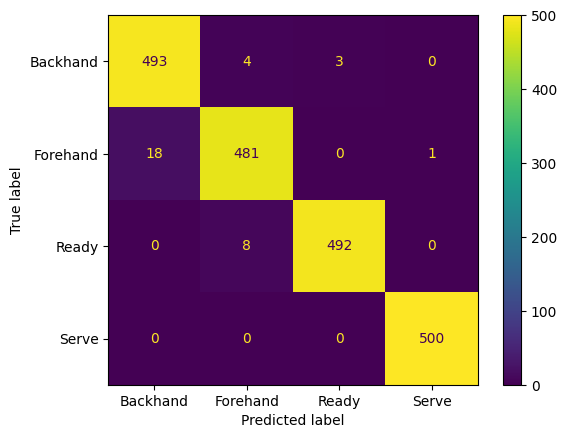

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, _, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        _, pred_class = model(images)
        _, predicted = torch.max(pred_class, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Backhand", "Forehand", "Ready", "Serve"])
disp.plot()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


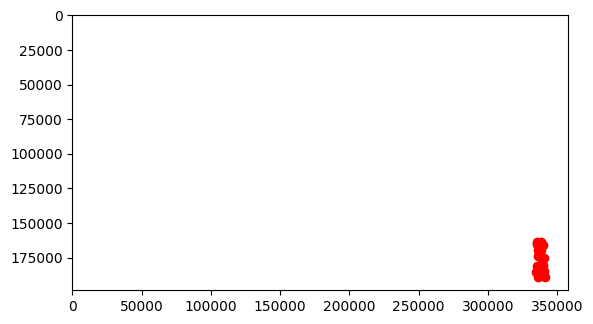

In [37]:
import matplotlib.pyplot as plt

def visualize_predictions(image, keypoints):
    image = image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)
    for (x, y) in keypoints:
        plt.plot(x * 1280, y * 720, 'ro')  # Scale back to pixel coordinates
    plt.show()

# Example usage
model.eval()
with torch.no_grad():
    image, _, _ = dataset[0]
    pred_keypoints, _ = model(image.unsqueeze(0).to(device))
    visualize_predictions(image, pred_keypoints[0].cpu().numpy())

In [38]:
torch.save(model.state_dict(), "final_pose_model.pth")

In [39]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=["Backhand", "Forehand", "Ready", "Serve"]))


              precision    recall  f1-score   support

    Backhand       0.96      0.99      0.98       500
    Forehand       0.98      0.96      0.97       500
       Ready       0.99      0.98      0.99       500
       Serve       1.00      1.00      1.00       500

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [40]:
cm = confusion_matrix(all_labels, all_preds)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print(f"Per-Class Accuracy: {per_class_accuracy}")

Per-Class Accuracy: [0.986 0.962 0.984 1.   ]


In [41]:
mae = torch.mean(torch.abs(pred_keypoints - keypoints)).item()
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 252.3976


In [42]:
def compute_pck(pred_keypoints, gt_keypoints, threshold=0.05):
    """Computes PCK metric."""
    distances = torch.norm(pred_keypoints - gt_keypoints, dim=2)  # Euclidean distance per keypoint
    correct = (distances < threshold).float()
    pck = correct.mean().item()  # Mean of all keypoints
    return pck

pck = compute_pck(pred_keypoints, keypoints)
print(f"PCK: {pck * 100:.2f}%")

PCK: 0.00%


In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(model)}")

Trainable Parameters: 11197032


In [45]:
for param_group in optimizer.param_groups:
    print(f"Current Learning Rate: {param_group['lr']}")

Current Learning Rate: 0.001


In [46]:
total_norm = 0
for p in model.parameters():
    if p.grad is not None:
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
total_norm = total_norm ** 0.5
print(f"Gradient Norm: {total_norm:.4f}")

Gradient Norm: 0.5744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Sample 1:
Label: 0
Keypoints:
tensor([[1513096216576,  732630614016,             1],
        [1500508061696,  725077721088,             1],
        [1523166740480,  720042459136,             1],
        [1490437537792,  742701137920,             2],
        [1535754895360,  737665875968,             2],
        [1492955168768,  795571388416,             2],
        [1538272526336,  762842185728,             2],
        [1482884644864,  881170841600,             2],
        [1508060954624,  873617948672,             2],
        [1437567287296,  898794258432,             2],
        [1455190704128,  906347151360,             2],
        [1543307788288,  929005830144,             2],
        [1598695669760,  916417675264,             2],
        [1465261228032, 1012087652352,             2],
        [1540790157312, 1007052390400,             2],
        [1518131478528, 1130416308224,             2],
        [1588625145856, 1102722367488,             2],
        [1518131478528,  7603245547

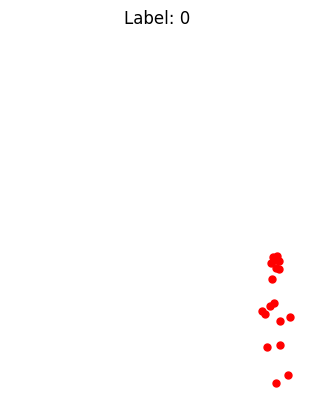

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Sample 2:
Label: 0
Keypoints:
tensor([[551, 301,   1],
        [540, 297,   1],
        [556, 293,   1],
        [539, 306,   1],
        [560, 302,   1],
        [551, 329,   2],
        [561, 321,   2],
        [546, 362,   2],
        [534, 353,   2],
        [518, 384,   2],
        [515, 375,   2],
        [573, 380,   2],
        [594, 375,   2],
        [532, 412,   2],
        [573, 417,   2],
        [537, 466,   2],
        [622, 431,   2],
        [554, 312,   2]])


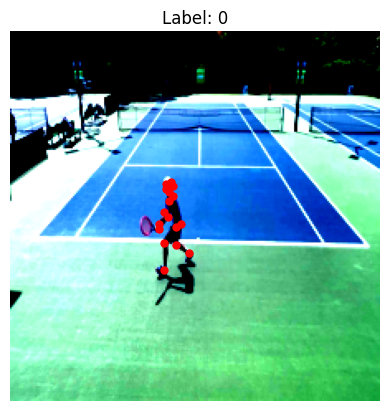

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Sample 3:
Label: 0
Keypoints:
tensor([[501, 307,   1],
        [490, 306,   1],
        [504, 303,   1],
        [488, 313,   2],
        [510, 308,   2],
        [507, 332,   2],
        [497, 326,   2],
        [505, 370,   2],
        [487, 358,   2],
        [476, 388,   2],
        [472, 386,   1],
        [533, 382,   2],
        [516, 378,   2],
        [498, 423,   2],
        [491, 412,   2],
        [533, 467,   2],
        [540, 430,   2],
        [504, 317,   2]])


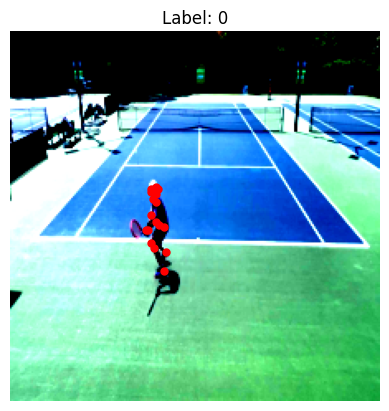

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Sample 4:
Label: 0
Keypoints:
tensor([[454, 292,   1],
        [443, 289,   2],
        [457, 285,   2],
        [443, 298,   1],
        [463, 294,   1],
        [461, 314,   2],
        [447, 313,   2],
        [474, 345,   2],
        [448, 342,   2],
        [446, 367,   2],
        [441, 365,   1],
        [487, 372,   2],
        [462, 368,   2],
        [454, 421,   2],
        [437, 397,   2],
        [505, 445,   2],
        [469, 439,   2],
        [457, 301,   2]])


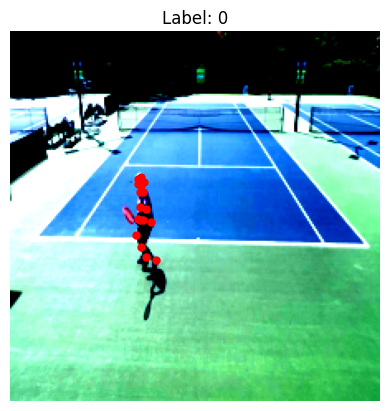

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Sample 5:
Label: 0
Keypoints:
tensor([[410, 294,   1],
        [401, 292,   1],
        [414, 288,   1],
        [399, 299,   2],
        [420, 294,   2],
        [418, 313,   2],
        [403, 313,   2],
        [428, 341,   2],
        [406, 338,   2],
        [399, 353,   2],
        [405, 359,   1],
        [446, 371,   2],
        [420, 364,   2],
        [416, 419,   2],
        [390, 392,   2],
        [453, 442,   2],
        [423, 422,   1],
        [412, 303,   2]])


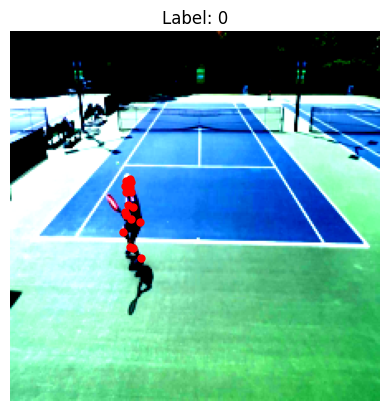

In [65]:
import matplotlib.pyplot as plt

def visualize_keypoints(image, keypoints, original_size=(1280, 720), title="Sample", color='r'):
    """Visualizes keypoints on an image."""
    # Convert image to NumPy for visualization
    image = image.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)

    # Get image dimensions (since it has been resized to 224x224)
    height, width = image.shape[:2]  # Should be 224x224 after transform

    # Rescale keypoints to match the resized image
    keypoints[:, 0] = keypoints[:, 0] / original_size[0] * width  # Scale x-coordinates
    keypoints[:, 1] = keypoints[:, 1] / original_size[1] * height  # Scale y-coordinates

    # Plot the image
    plt.imshow(image)
    plt.title(title)

    # Plot the keypoints on the image
    for x, y in keypoints:
        plt.plot(x, y, color + 'o', markersize=5)

    plt.axis('off')
    plt.show()

def print_dataset_sample(dataset, sample_count=5):
    """Print and visualize sample images with keypoints and labels."""
    for i in range(min(sample_count, len(dataset))):
        # Extract a sample from the dataset
        image, keypoints, label = dataset[i]

        # Print keypoints and label for debugging
        print(f"Sample {i + 1}:")
        print(f"Label: {label}")
        print(f"Keypoints:\n{keypoints}")

        # Visualize the image with keypoints
        visualize_keypoints(image, keypoints[:, :2], title=f"Label: {label}")

# Print and visualize 5 samples from the dataset
print_dataset_sample(dataset, sample_count=5)
